# This is the most up to date motor control example. Refer here to work with the FPGA through the network connection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("..")
sys.path.append("../../")

from armControl import *
from forwardKinematics import robot_config
from utils.motor_setup import CableReduction
import signal

import matplotlib.pyplot as plt


In [2]:
socket_ip = '192.168.0.101'
socket_port = 1123

#trajPlanner = trajectoryGenerator()

motors = CableReduction()
motors.tcp_init(socket_ip, socket_port)

Opening socket at ip: 192.168.0.101 using port: 1123


In [3]:
print("Arming motors now...")
motors.arm_motors()

Arming motors now...
initializing motors to [0 0 0 0 0 0 0 0]
*** C side has an error or needs to be armed ***

Arming motors


In [8]:
motors.tcp_close()

In [4]:
setpoints = np.zeros(8)#np.ones(8)*3.14/8
setpoints[6] = np.pi*8
velocity = np.ones(8)*np.pi*8
dt = 0.005
runtime = 1
num_elements = int(runtime/dt)
frequency = 0.5

motors.run_trajectory(setpoints, velocity)
motors.run_trajectory(np.zeros(8), velocity)

0

In [6]:
setpoint = np.zeros(8)
currents_left = []
counts_left = []
while motors.avg_current[0] < 0.45:
    setpoint = setpoint + 0.01
    currents_left.append(motors.avg_current[0])
    counts_left.append(motors.get_motors_position_radians())
    motors.command_motors_radians(setpoint)
    time.sleep(0.01)
zero_left = motors.get_motors_position_radians()

motors.run_trajectory(np.zeros(8), velocity)

setpoint = np.zeros(8)    
currents_right = []
counts_right = []
while motors.avg_current[0] < 0.45:
    setpoint = setpoint - 0.01
    currents_right.append(motors.avg_current[0])
    counts_right.append(motors.get_motors_position_radians())
    motors.command_motors_radians(setpoint)
    time.sleep(0.01)
zero_right = motors.get_motors_position_radians()

motor_zero_new = (zero_right[7] + zero_left[7])/2
motors.zero_motors_radians(7, motor_zero_new)

motors.run_trajectory(np.zeros(8), velocity)
print(motor_zero_new)

0.0


IndexError: too many indices for array

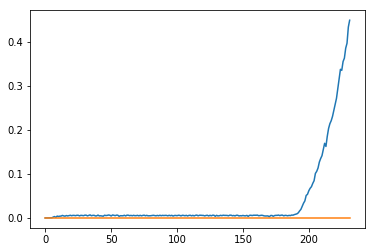

In [7]:
currents_left = np.array(currents_left)
counts_left = np.array(counts_left)
currents_right = np.array(currents_right)
counts_right = np.array(counts_right)
plt.plot(currents_left)
plt.plot(np.abs(counts_left[:,7])/10)
plt.plot(currents_right)
plt.plot(np.abs(counts_right[:,7])/10)

In [ ]:
dt = 0.005
runtime = 10
num_elements = int(runtime/dt)
setpoints = np.zeros((num_elements, 8))
frequency = 0.5
for i in range(num_elements):
    setpoints[i,:] = (np.ones(8) * np.sin(i*dt*2*pi*frequency)*3.14/3)


start_time = time.time()

currents_mA = []
for i in range(num_elements):
    current_time = time.time()
    #print(enc_position)
    setpoint = setpoints[i]
    motors.command_motors_radians(setpoint)
    currents_mA.append(1000*motors.avg_current)
    time.sleep(dt)
    
motors.run_trajectory(np.zeros(8), velocity)

plt.plot(currents_mA)

In [ ]:
motors.tcp_close()